In [39]:
# cell_number: 1

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

# 크롬 드라이버 설정
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
driver.get("https://www.chosun.com/national/")

# 기사 더보기 반복 클릭
max_clicks = 1
for _ in range(max_clicks):
    try:
        button = driver.find_element(By.ID, "load-more-stories")
        driver.execute_script("arguments[0].click();", button)
        time.sleep(2)
    except:
        print("더보기 버튼이 없거나 모든 기사를 로드했습니다.")
        break

# 기사 제목과 링크 수집
articles = []
cards = driver.find_elements(By.CSS_SELECTOR, "a.story-card__headline")
for card in cards:
    try:
        title = card.text.strip()
        link = card.get_attribute("href")
        if title and link:
            articles.append((title, link))
    except:
        continue

df = pd.DataFrame(articles, columns=["Title", "Link"])
print(f"총 수집된 기사 수: {len(df)}")
print(df.head())


총 수집된 기사 수: 45
                                  Title  \
0              경찰, '내란 혐의' 한덕수·최상목 출국금지   
1       단독제주에 13년 뿌리내린 탈북민, 알고 보니 간첩이었다   
2  13년간 의붓딸 2092회 성폭력\n뒤늦게 안 친모는 목숨 끊었다   
3     주유건 꽂은 채 달린 운전자\n'빵빵' 경적에 보인 반응이…   
4    단독출근 40분전 상사 카톡, 직장내 괴롭힘일까… 법원 판단은   

                                                Link  
0  https://www.chosun.com/national/national_gener...  
1  https://www.chosun.com/national/court_law/2025...  
2  https://www.chosun.com/national/national_gener...  
3  https://www.chosun.com/national/national_gener...  
4  https://www.chosun.com/national/national_gener...  


In [40]:
# cell_number: 2

from selenium.webdriver.common.by import By
from tqdm import tqdm

# 기사 본문 수집 함수 (Selenium 기반)
def get_article_text_selenium(url):
    try:
        driver.get(url)
        time.sleep(2)
        section = driver.find_element(By.CLASS_NAME, "article-body")
        paragraphs = section.find_elements(By.TAG_NAME, "p")
        return " ".join(p.text.strip() for p in paragraphs if p.text.strip())
    except Exception as e:
        print(f"[본문 오류] {url} - {e}")
        return ""

# tqdm 적용
df["Content"] = [get_article_text_selenium(link) for link in tqdm(df["Link"])]

# 기사 내용 통계 확인
df["Content_len"] = df["Content"].apply(len)
print("==== 전체 본문 길이 평균 ====")
print(df["Content_len"].mean())
print("\n==== 본문 샘플 ====")
print(df["Content"].iloc[0][:300])


100%|██████████| 45/45 [02:12<00:00,  2.94s/it]

==== 전체 본문 길이 평균 ====
997.9555555555555

==== 본문 샘플 ====
12·3 비상계엄 사태를 수사하는 경찰이 내란 혐의로 입건된 한덕수 전 국무총리와 최상목 전 경제부총리 겸 기획재정부 장관을 출국 금지했다고 27일 밝혔다. 경찰에 따르면, 경찰청 국가수사본부 비상계엄 특별수사단은 한 전 총리와 최 전 부총리에 대해 최근 출국금지 조처를 했다. 이들은 지난해 12월 3일 계엄령 선포 전 국무회의에 참석, 내란에 동조한 혐의로 경찰 수사를 받고 있다. 앞서 경찰은 전날 한 전 총리와 최 전 부총리, 이상민 전 행정안전부 장관을 내란 혐의 피의자 신분으로 동시에 불러 조사했었다. 세 전직 국무위원은 작


In [41]:
# cell_number: 3

from kiwipiepy import Kiwi
from collections import Counter
import re

kiwi = Kiwi()
stopwords = {"기자", "관련", "제공", "오늘", "보도", "최근", "위해", "대한"}

def clean_and_extract_nouns(text):
    text = re.sub(r"[^가-힣\s]", "", text)
    result = kiwi.analyze(text, top_n=1)[0][0]
    nouns = [word for word, tag, _, _ in result if tag.startswith("NN") and word not in stopwords and len(word) > 1]
    return nouns

# 전체 기사에서 명사 추출
all_nouns = []
for article in tqdm(df["Content"], desc="Kiwi 분석"):
    all_nouns.extend(clean_and_extract_nouns(article))

noun_freq = Counter(all_nouns)
print(f"총 추출 명사 수: {len(noun_freq)}")


Kiwi 분석: 100%|██████████| 45/45 [00:01<00:00, 25.64it/s]

총 추출 명사 수: 1896


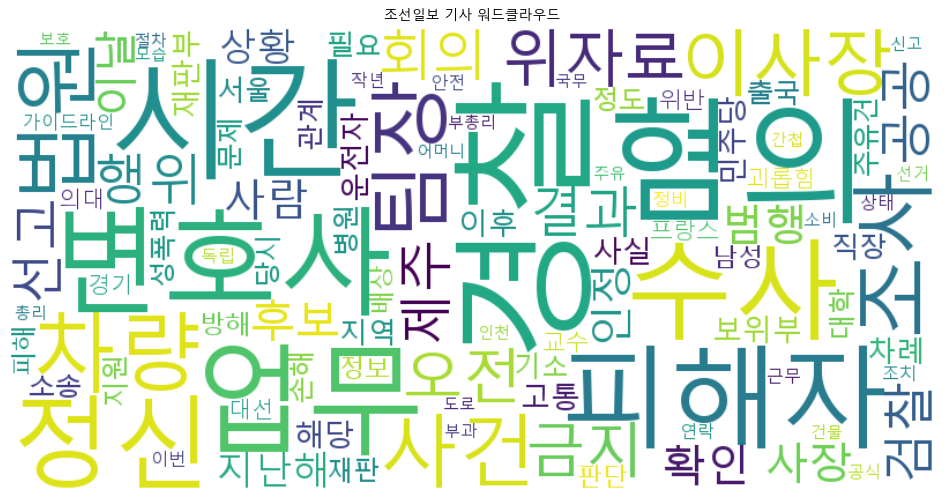

In [42]:
# cell_number: 4

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 (윈도우용 예시)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()  # matplotlib 기본 한글 폰트로 지정

from wordcloud import WordCloud

top_nouns = dict(noun_freq.most_common(100))

if not top_nouns:
    print("워드클라우드를 생성할 단어가 없습니다.")
else:
    wordcloud = WordCloud(
        font_path=font_path,
        background_color='white',
        width=800,
        height=400
    ).generate_from_frequencies(top_nouns)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("조선일보 기사 워드클라우드", fontsize=20, fontproperties=font_prop)
    plt.show()
